# 1. Load and Use the CNN Model for Prediction

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Define the same CNN model class again
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, 3), nn.ReLU(), nn.MaxPool2d(2, 2),
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 512), nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = self.classifier(x)
        return x

# Load model
model = CNNClassifier(num_classes=2)
model.load_state_dict(torch.load("catsanddogs_classifier.pth", map_location=torch.device('cpu')))
model.eval()


CNNClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)

 # 2. Image Transformations and Prediction Function

In [3]:
# Same transforms used during validation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            label = "Dog" if predicted.item() == 1 else "Cat"
            confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()
            return label, confidence
    except Exception as e:
        print(f"Error: {e}")
        return None, None


 # 3. Predict and Show Results on Sample Images

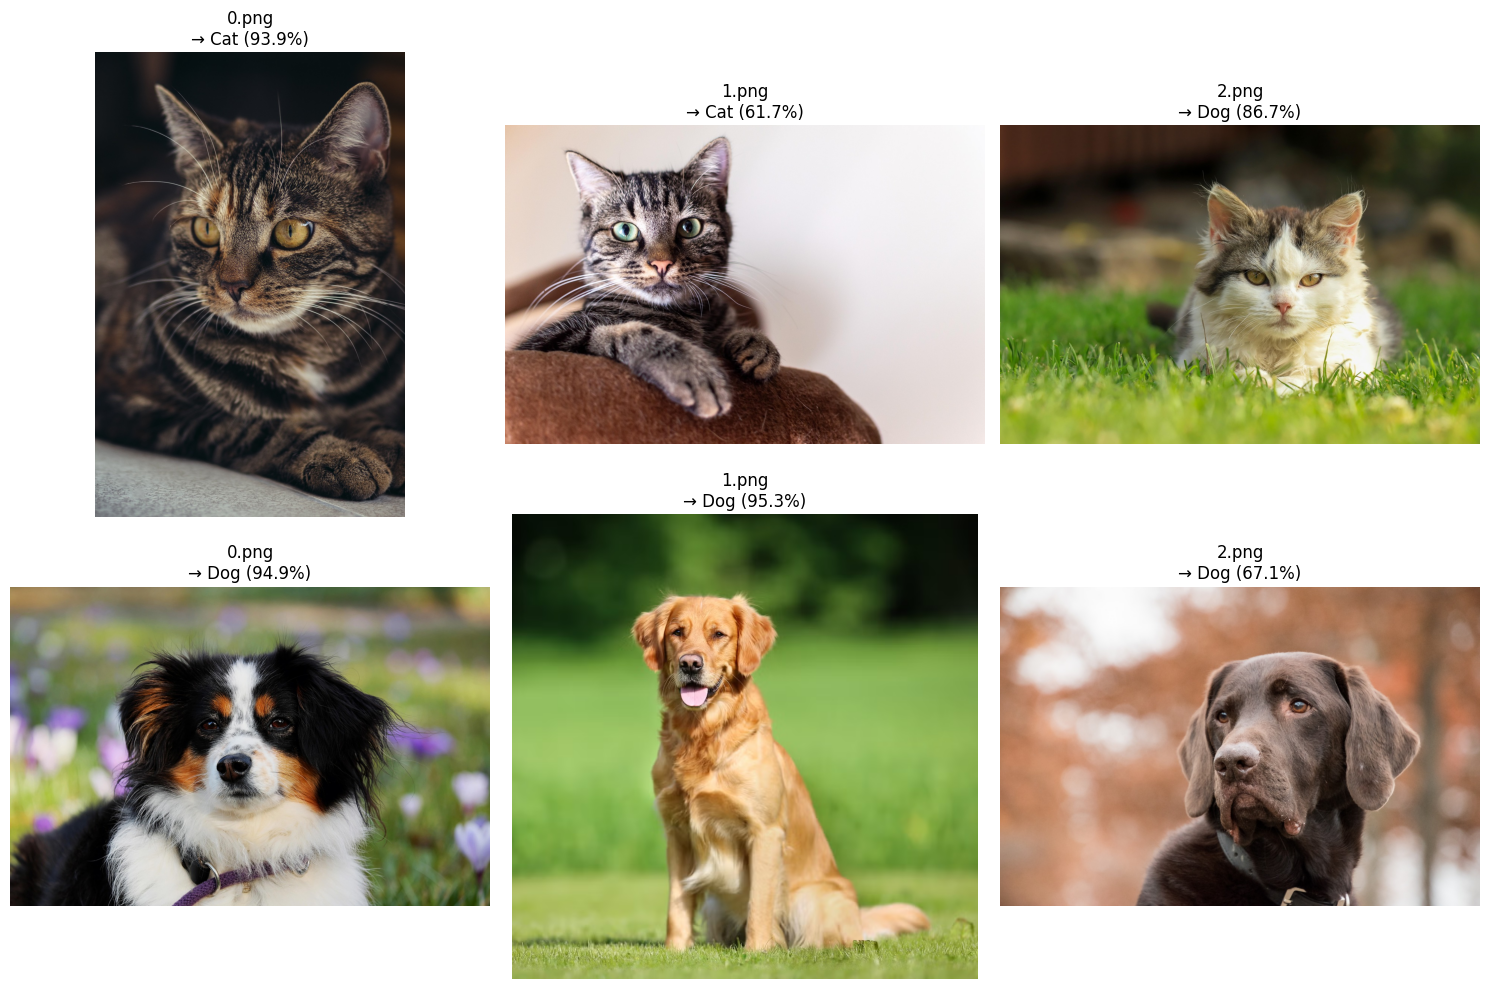

In [4]:
# Paths to sample image folders
cat_folder = "dataset/sample_images/cats"
dog_folder = "dataset/sample_images/dogs"

image_paths = []
for folder in [cat_folder, dog_folder]:
    for file in os.listdir(folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_paths.append(os.path.join(folder, file))

plt.figure(figsize=(15, 10))

for i, path in enumerate(image_paths[:6], 1):  # Limit to 6 images
    label, confidence = predict_image(path)
    img = Image.open(path)
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(f"{os.path.basename(path)}\n→ {label} ({confidence*100:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.savefig('cnn_predictions.jpg')
plt.show()
